# Question 4: What is the sentiment towards cycling in London?

Tweets scraped from Twitter on 11-Aug-2022.

## Prepare workstation

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

Rationale for turning off warnings: Warnings usually occur when there are obsolete programming elements. Warnings have been turned off to make the code cleaner. Turning off warnings will still allow warnings to appear

In [3]:
# Install tweepy
!pip install tweepy
import tweepy
from tweepy import OAuthHandler
import time

In [4]:
# Install Twitter API
!pip install twitter

In [5]:
# Import library
from twitter import *

In [6]:
#Create Twitter API variables
consumer_key = "XXX"
consumer_key_secret = "XXX"
access_token = "XXX"
access_token_secret = "XXX"

Note: X's need to be replaced with custom keys and tokens. The code was initially run with individual custom keys and tokens but these were replaced with X's afterward for privacy purposes so that the code could be shared more widely.

In [7]:
# Twitter authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

## Scrape Twitter based on search term 'london uk cycle'

In [8]:
#Create an empty variable
tweets = []

# Define search criteria
def text_query_to_csv(text_query, recent):
    try:
        tweets = tweepy.Cursor(api.search_tweets, q=text_query, tweet_mode="extended").items(recent)
        tweets_list = [[tweet.created_at, tweet.id, tweet.full_text] for tweet in tweets]
        tweets_df = pd.DataFrame(tweets_list,columns=['Datetime', 'Tweet Id', 'Text'])
        tweets_df.to_csv('{}-tweets.csv'.format(text_query), sep=',', index = False)
    except BaseException as e:
        print('failed on_status,',str(e))
        time.sleep(3)

#Define the term of interest and the number of tweets associated with the term to be scraped
text_query = 'london uk cycle -filter:retweets'
recent= 1000000

# Query the relevant tweets and convert the data to a CSV file
text_query_to_csv(text_query, recent)

Search criteria "london uk cycle -filter:retweets' used to limit search to London, UK (when 'london cycle' was used, some search results were referencing London, Ontario). Retweets were filtered to reduce duplicates and to allow the entire tweet to display when exmaining the top 20 positive and negative reviews.

In [9]:
# Convert CSV file to Pandas dataframe
london_cycle_tweets_pd = pd.read_csv("london uk cycle -filter:retweets-tweets.csv")

In [10]:
# Examine first few rows of dataframe
london_cycle_tweets_pd.head()

Datetime             Tweet Id  \
0  2022-08-11 16:01:27+00:00  1557759106169323521   
1  2022-08-11 13:19:03+00:00  1557718237735002113   
2  2022-08-11 12:59:18+00:00  1557713267329466368   
3  2022-08-11 11:35:58+00:00  1557692296577286144   
4  2022-08-11 11:33:04+00:00  1557691565124079620   

                                                Text  
0  @AliceDove7 @Hackneycyclist In the UK there is...  
1  Many of you can‚Äôt stand cyclists. I cycle ever...  
2  For anyone attending the @edintfest this summe...  
3  Challenge yourself whilst helping a great caus...  
4  My friend‚Äôs husband is doing the London to Bri...

In [11]:
london_cycle_tweets_pd.iloc[2,2]

"For anyone attending the @edintfest this summer don't miss Austrian baritone Florian Boesch and pianist Malcolm Martineau's performance of Schubert's song cycle #Winterreise, charged with forceful intensity and subtle theatricality. https://t.co/FdofVC84uy https://t.co/tvDZoEwOvO"

In [12]:
# Examine shape of dataframe
london_cycle_tweets_pd.shape

(84, 3)

## Clean dataframe

In [13]:
# Extract column containing all the reviews for analysing the text
london_cycle_tweets_pd = pd.DataFrame(london_cycle_tweets_pd['Text'])
london_cycle_tweets_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    84 non-null     object
dtypes: object(1)
memory usage: 800.0+ bytes


In [14]:
# Remove missing values
london_cycle_tweets_pd.dropna(subset=['Text'], inplace=True)
london_cycle_tweets_pd.shape

(84, 1)

In [15]:
# Convert sentences into lowercase
london_cycle_tweets_pd['Text'] = london_cycle_tweets_pd['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
london_cycle_tweets_pd['Text'].head()

0    @alicedove7 @hackneycyclist in the uk there is...
1    many of you can‚Äôt stand cyclists. i cycle ever...
2    for anyone attending the @edintfest this summe...
3    challenge yourself whilst helping a great caus...
4    my friend‚Äôs husband is doing the london to bri...
Name: Text, dtype: object

In [16]:
# Remove punctuation
london_cycle_tweets_pd['Text'] = london_cycle_tweets_pd['Text'].str.replace('[^\w\s]','', regex=False)
london_cycle_tweets_pd['Text'].head()

0    @alicedove7 @hackneycyclist in the uk there is...
1    many of you can‚Äôt stand cyclists. i cycle ever...
2    for anyone attending the @edintfest this summe...
3    challenge yourself whilst helping a great caus...
4    my friend‚Äôs husband is doing the london to bri...
Name: Text, dtype: object

In [17]:
# Check the number of duplicate values in the reviewText column
london_cycle_tweets_pd.Text.duplicated().sum()

0

In [18]:
# Drop duplicates
london_cycle_tweets_pdclean = london_cycle_tweets_pd.drop_duplicates(subset=['Text'])

In [19]:
# Reset index and preview cleaned data
london_cycle_tweets_pdclean.reset_index(inplace=True)
london_cycle_tweets_pdclean.head()

index                                               Text
0      0  @alicedove7 @hackneycyclist in the uk there is...
1      1  many of you can‚Äôt stand cyclists. i cycle ever...
2      2  for anyone attending the @edintfest this summe...
3      3  challenge yourself whilst helping a great caus...
4      4  my friend‚Äôs husband is doing the london to bri...

In [20]:
# Examine shape of cleaned data
london_cycle_tweets_pdclean.shape

(84, 2)

## Convert text into tokens

In [21]:
# Import nltk packages for converting text into tokens
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /Users/mhbilas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
# Apply tokens
london_cycle_tweets_pdclean['tokens'] = london_cycle_tweets_pdclean['Text'].apply(word_tokenize)
london_cycle_tweets_pdclean['tokens'].head()

0    [@, alicedove7, @, hackneycyclist, in, the, uk...
1    [many, of, you, can, ‚Äô, t, stand, cyclists, .,...
2    [for, anyone, attending, the, @, edintfest, th...
3    [challenge, yourself, whilst, helping, a, grea...
4    [my, friend, ‚Äô, s, husband, is, doing, the, lo...
Name: tokens, dtype: object

In [23]:
# Combine tokens into one list
all_tokens = []
for i in range(london_cycle_tweets_pdclean.shape[0]):
    all_tokens = all_tokens + london_cycle_tweets_pdclean['tokens'][i]

In [24]:
# Filter out tokens that are neither alphabets or numbers (to eliminate punctuation marks etc)
tokens1 = [word for word in all_tokens if word.isalnum()]

## Eliminate stopwords

In [25]:
# Download the nltk resource, import the method, and extract stopwords in the English language.
nltk.download ('stopwords')
from nltk.corpus import stopwords
english_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mhbilas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
# Create a list of tokens from the list of identified tokens after eliminating stopwords
tokens2 = [x for x in tokens1 if x.lower() not in english_stopwords]

In [27]:
# Create empty list to store values from list of identified tokens after eliminating stopwords
tokens2_string = ''
for value in tokens2:
    tokens2_string = tokens2_string + value + ' '

## Plot wordcloud

In [28]:
# Import WordCloud
!pip install wordcloud
from wordcloud import WordCloud

In [29]:
# Set parameters for wordcloud image
wordcloud = WordCloud(width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(tokens2_string)

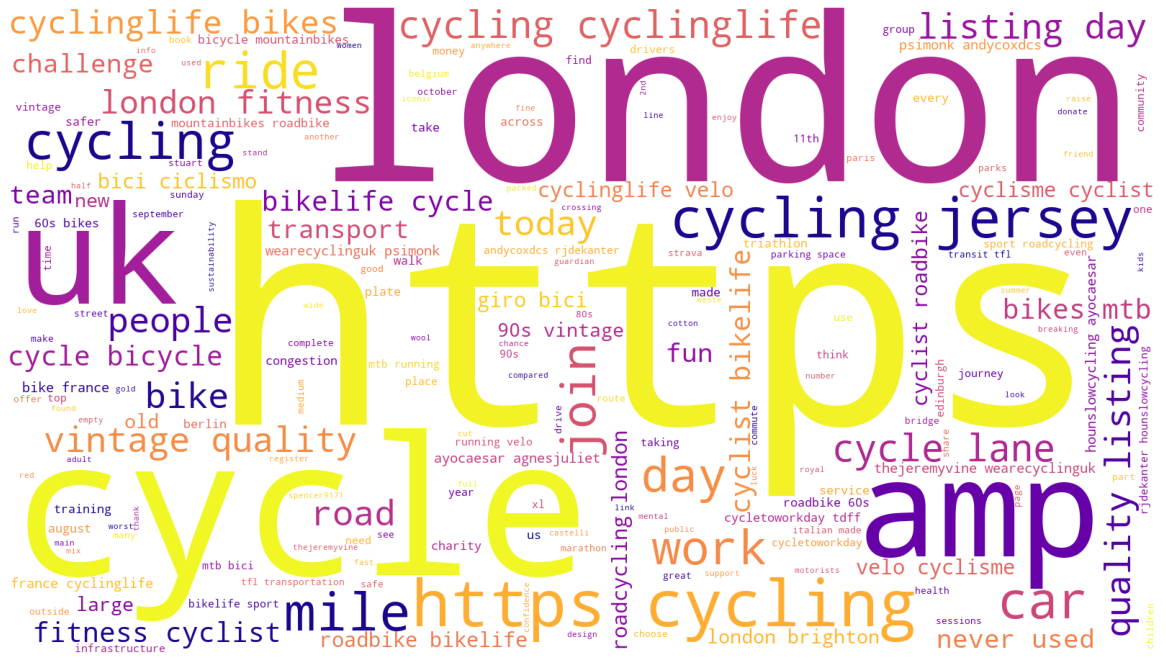

In [30]:
# Plot the WordCloud image                        
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

Note: "rt" stands for retweet and "b" is added when we specify that we want to include the full extended tweet. "https" adds no value to the analysis - therefore, we will exclude these terms from the analysis.

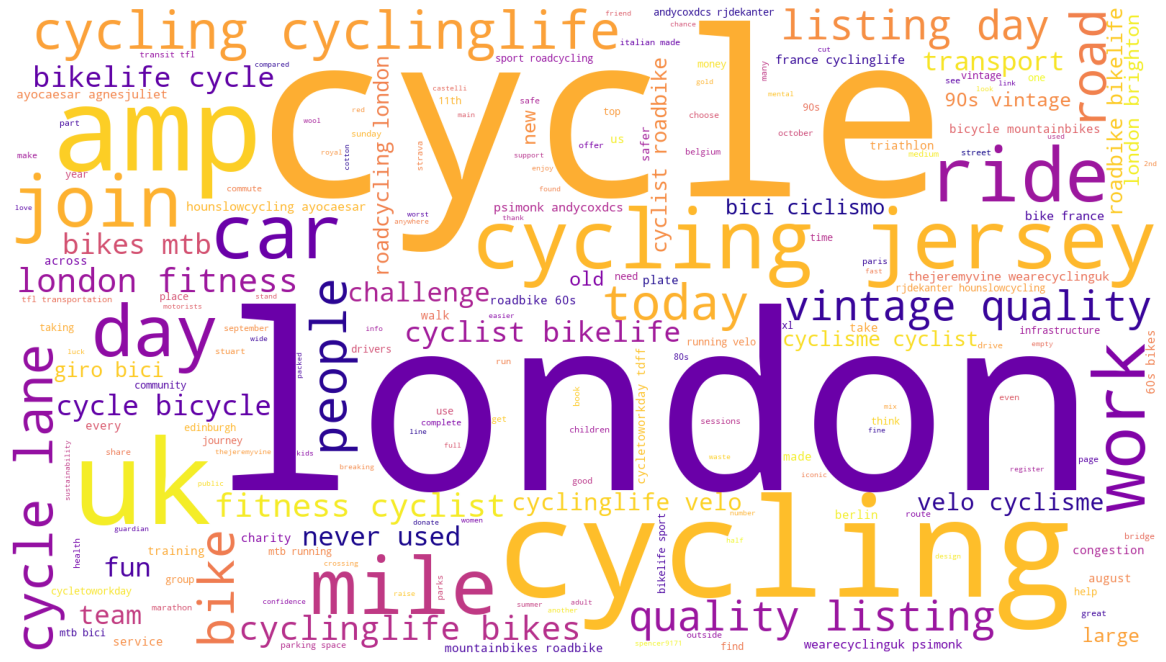

In [31]:
# Re-generate wordcloud with https and rt removed
all_text = " ".join(rev for rev in tokens2)
stop_words = ["https", "rt", "b"]

# Set paramters for image
wordcloud = WordCloud(stopwords=stop_words,width = 1600, height = 900, 
                background_color ='white', 
                colormap='plasma', 
                min_font_size = 10).generate(all_text)

# Plot wordcloud image
plt.figure(figsize = (16, 9), facecolor = None) 
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0) 
plt.show()

## Generate top 15 words that appear most often

In [32]:
# View the frequency distribution
from nltk.probability import FreqDist
fdist1 = FreqDist(tokens2)
fdist1

FreqDist({'https': 110, 'london': 73, 'cycle': 71, 'cycling': 48, 'bikes': 21, 'uk': 19, 'amp': 19, 'cyclist': 19, 'vintage': 18, 'day': 17, ...})

In [33]:
# Remove 'https' from list of tokens
remove_words = ["https", "rt", "b"]
tokens_new_list = [x for x in tokens2 if x not in remove_words]

# Compare length of tokens2 vs tokens_new_list to see if https and rt was removed
print(len(tokens2))
print(len(tokens_new_list))

2044
1934


In [34]:
# Generate frequency distribution with 'https' and 'rt' removed
fdist2 = FreqDist(tokens_new_list)
fdist2

FreqDist({'london': 73, 'cycle': 71, 'cycling': 48, 'bikes': 21, 'uk': 19, 'amp': 19, 'cyclist': 19, 'vintage': 18, 'day': 17, 'bikelife': 17, ...})

In [35]:
# Generate top 15 commonly used words

# Import counter
from collections import Counter

# Generate dataframe out of counter
counts = pd.DataFrame(Counter(tokens_new_list).most_common(15),
                      columns=['Word', 'Frequency']).set_index('Word')
counts

Frequency
Word                  
london              73
cycle               71
cycling             48
bikes               21
uk                  19
amp                 19
cyclist             19
vintage             18
day                 17
bikelife            17
cyclinglife         16
roadbike            16
velo                16
bike                14
quality             11

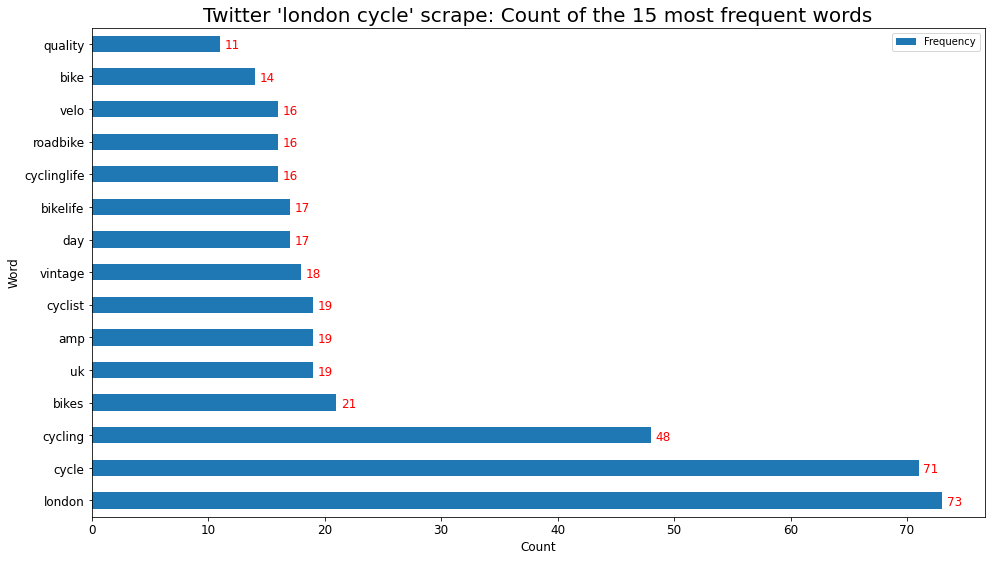

In [36]:
# Generate bar graph with frequencies
ax = counts.plot(kind='barh', fontsize=12, figsize=(16,9))
ax.set_xlabel("Count", fontsize=12)
ax.set_ylabel("Word", fontsize=12)
ax.set_title("Twitter 'london cycle' scrape: Count of the 15 most frequent words", fontsize=20)

# Add annotations
for i in ax.patches:
    ax.text(i.get_width()+.41, i.get_y()+.1, str(round((i.get_width()), 2)), fontsize=12, color="red")

## Generate polarity score

In [37]:
# Install TextBlob
!pip install textblob

# Import
from textblob import TextBlob

In [38]:
# Define a function to extract a polarity score for a tweet
def generate_polarity(tweet):
    return TextBlob(tweet).sentiment[0]

In [39]:
# Populate a new column with polarity score for each tweet
london_cycle_tweets_pdclean['polarity'] = london_cycle_tweets_pdclean['Text'].apply(generate_polarity)

In [40]:
# Preview the results
london_cycle_tweets_pdclean['polarity'].head()

0   -0.300000
1    0.123106
2   -0.333333
3    0.204167
4   -0.187500
Name: polarity, dtype: float64

## Visualise sentiment polarity scores


### Histogram

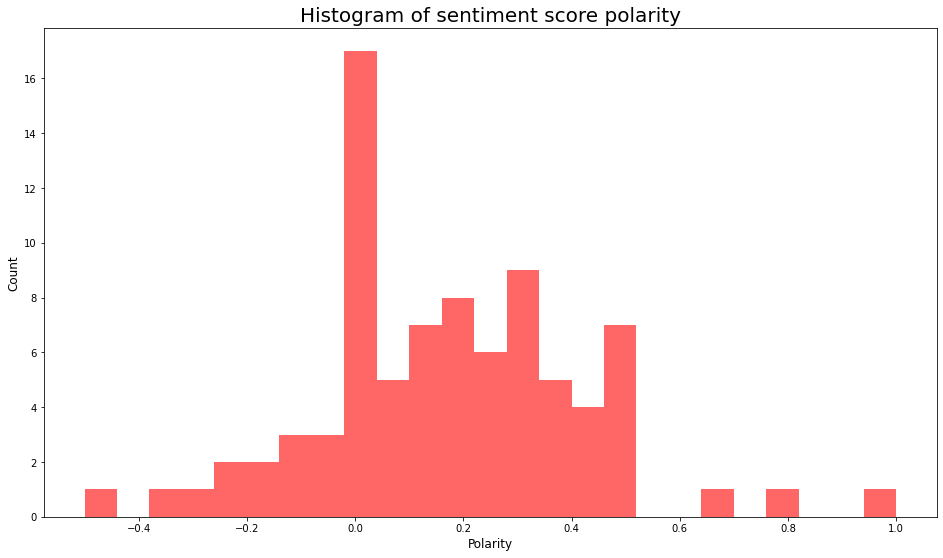

In [41]:
# Set the number of bins
num_bins = 25

# Set the plot area
plt.figure(figsize=(16,9))

# Define the number of bins
n, bins, patches = plt.hist(london_cycle_tweets_pdclean['polarity'], \
                            num_bins, facecolor='red', alpha=0.6)
# Set the labels
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Histogram of sentiment score polarity', fontsize=20)

plt.show()

### Boxplot

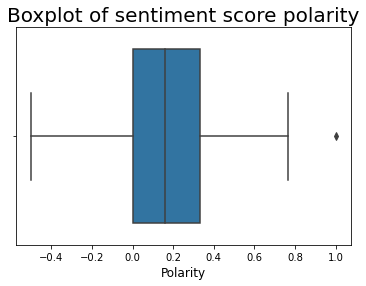

In [42]:
# Define type of plot
sns.boxplot(x='polarity', data=london_cycle_tweets_pdclean)

# Set the labels
plt.xlabel('Polarity', fontsize=12)
plt.title('Boxplot of sentiment score polarity', fontsize=20)

plt.show()

## Extract top 20 positive and negative tweets

### Top 20 positive tweets

In [43]:
# Create dataframe to store top 20 tweets
positive_sentiment = london_cycle_tweets_pdclean.nlargest(20, 'polarity')
positive_sentiment

index                                               Text  \
66     66  it‚Äôs #cycletoworkday, marking 10 years of the ...   
73     73  happy 10th birthday to cycle to work day! our ...   
72     72  #cycletoworkday is celebrating its 10th birthd...   
17     17  "i hadn‚Äôt anticipated the power of a group of ...   
20     20  cycle response unit shortlisted for top award ...   
44     44  add your voice to our work to ensure everyone ...   
45     45  üîß city &amp; guilds - level 1 cycle mechanics ...   
62     62  some more just up #cycling jerseys see them on...   
13     13  set yourself a challenge to run and fundraise ...   
16     16  do you enjoy cycling? or perhaps you love a ch...   
70     70  transport: better transport needs to be more a...   
27     27  transport for london to fine motorists who dri...   
33     33  breaking - conservatives announce speed limit ...   
15     15  @kidicalmassread @zulueleven @cyclinglawldn wh...   
69     69  @amotorcyclist @claytonbuckland @andycarolan i...   
83     83  now more than ever, we need fundraisers to joi...   
34     34  today is the day when stuart norris from stamf...   
41     41  @thejeremyvine @silvertowntn @rbkc @londoncoun...   
36     36  #cycling jerseys in large plus 550 more to cho...   
74     74  get ready to join in on the fun. get that bike...   

                                               tokens  polarity  
66  [it, ‚Äô, s, #, cycletoworkday, ,, marking, 10, ...  1.000000  
73  [happy, 10th, birthday, to, cycle, to, work, d...  0.766667  
72  [#, cycletoworkday, is, celebrating, its, 10th...  0.650000  
17  [``, i, hadn, ‚Äô, t, anticipated, the, power, o...  0.500000  
20  [cycle, response, unit, shortlisted, for, top,...  0.500000  
44  [add, your, voice, to, our, work, to, ensure, ...  0.500000  
45  [üîß, city, &, amp, ;, guilds, -, level, 1, cycl...  0.500000  
62  [some, more, just, up, #, cycling, jerseys, se...  0.500000  
13  [set, yourself, a, challenge, to, run, and, fu...  0.493750  
16  [do, you, enjoy, cycling, ?, or, perhaps, you,...  0.468750  
70  [transport, :, better, transport, needs, to, b...  0.438300  
27  [transport, for, london, to, fine, motorists, ...  0.416667  
33  [breaking, -, conservatives, announce, speed, ...  0.411111  
15  [@, kidicalmassread, @, zulueleven, @, cycling...  0.400000  
69  [@, amotorcyclist, @, claytonbuckland, @, andy...  0.375000  
83  [now, more, than, ever, ,, we, need, fundraise...  0.375000  
34  [today, is, the, day, when, stuart, norris, fr...  0.368750  
41  [@, thejeremyvine, @, silvertowntn, @, rbkc, @...  0.366667  
36  [#, cycling, jerseys, in, large, plus, 550, mo...  0.357143  
74  [get, ready, to, join, in, on, the, fun, ., ge...  0.335000

In [44]:
# Only retain neccessary columns
positive_sentiment = positive_sentiment[['Text', 'polarity']].reset_index(drop=True)

In [45]:
# Adjust column width
positive_sentiment.style.set_properties(subset=['Text'], **{'width': '1200px'})

In [46]:
positive_sentiment.iloc[0,0]

'it‚Äôs #cycletoworkday, marking 10 years of the uk‚Äôs biggest #cycle commuting event. https://t.co/ilipis5fe1 is perfectly positioned to take advantage of the infrastructure investment that has been made to encourage #cycling in london, with the cycle superhighway on our doorstep. https://t.co/zr2vvfrhfr'

### Top 20 negative tweets

In [47]:
# Create dataframe to store top 20 tweets
negative_sentiment = london_cycle_tweets_pdclean.nsmallest(20, 'polarity')

In [48]:
# Only retain neccessary columns
negative_sentiment = negative_sentiment[['Text', 'polarity']].reset_index(drop=True)

In [49]:
# Adjust column width
negative_sentiment.style.set_properties(subset=['Text'], **{'width': '1200px'})